# <span style="color:#35BCE9">Sandbox</span>
Main Objective: <em>Simple, working, command-line based iteration of GAN Image Generator</em>
<br/><br/>
<u>Inputs</u><br/>
Train images, both true and imposter
<br/><br/>
<u>Outputs</u><br/>
Generated image mimicking true

## <span style="color:#35BCE9">Phase I: Load Train Images</span>

#### Imports

In [1]:
import os
import numpy as np
from matplotlib import pyplot as plt

import torch
from torch import nn
from torch.nn import Module
from torch.utils.data import DataLoader, Dataset
from torch.optim import Adam

import torchvision
from torchvision import transforms

In [2]:
import cv2
import glob
import time

In [3]:
# Image Directory
cwd = os.getcwd()
parent_dir = os.path.dirname(cwd)
image_dir = os.path.join(parent_dir, 'Images')
os.listdir(image_dir)

['TestImages', '.DS_Store', 'ResultImages', 'TrainingImages']

#### PyTorch Data Handling

In [4]:
class ImageDataset(Dataset):
    def __init__(self, imagePaths):
        # data loading
        self.imagePaths = imagePaths
        self.TARGET_HEIGHT = 256
        self.TARGET_WIDTH = 256

    def __len__(self):
        # len()
        return len(self.imagePaths)

    def __getitem__(self, idx):
        # indexing
        image = cv2.imread(self.imagePaths[idx])
        imageRgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        resizedImage = self.resizeImage(imageRgb)
        float32Image = torch.tensor(resizedImage, dtype=torch.float32)
        imageTensor = float32Image.permute(2, 0, 1) / 255.0 # Normalize
        #finalTensor = imageTensor.unsqueeze(0)
        return imageTensor # [1, 3, 256, 256]
    
    def resizeImage(self, image):
        # resize to target width and height
        image = cv2.resize(image, (self.TARGET_WIDTH, self.TARGET_HEIGHT))
        height, width = image.shape[:2]
        
        # Pad image if below the target size
        top = bottom = (self.TARGET_HEIGHT - height) // 2
        left = right = (self.TARGET_WIDTH - width) // 2

        # Apply padding 
        paddedImage = cv2.copyMakeBorder(
            image, top, bottom, left, right, cv2.BORDER_CONSTANT, value=(0, 0, 0)
        )

        return paddedImage

    def showImage(self, idx):
        imageTensor = self[idx]
        np_image = imageTensor.detach().cpu().numpy()
        if np_image.ndim == 3 and np_image.shape[0] == 3: # Check if it's a 3-channel image
            np_image = np.transpose(np_image, (1, 2, 0))

        plt.imshow(np_image)
        plt.axis('off') # Turn off axis labels and ticks
        plt.show()

In [5]:
imageFolder = f"{image_dir}/TrainingImages/Goth"
imagePaths = glob.glob(f"{imageFolder}/*.jpg") + glob.glob(f"{imageFolder}/*.png")

dataset = ImageDataset(imagePaths=imagePaths)

In [6]:
imageFolder

'/Users/andrewturangan/Local/GanAnime/Images/TrainingImages/Goth'

In [7]:
dataset[0]

tensor([[[0.8706, 0.8784, 0.8784,  ..., 0.8667, 0.8627, 0.8863],
         [0.8667, 0.8784, 0.8667,  ..., 0.6863, 0.8745, 0.8824],
         [0.8824, 0.8706, 0.8196,  ..., 0.6078, 0.8745, 0.8824],
         ...,
         [0.9216, 0.9098, 0.9098,  ..., 0.8314, 0.8314, 0.9255],
         [0.9059, 0.8902, 0.9176,  ..., 0.9176, 0.9176, 0.9255],
         [0.9098, 0.9137, 0.9216,  ..., 0.9098, 0.9059, 0.8980]],

        [[0.8510, 0.8588, 0.8549,  ..., 0.8471, 0.8431, 0.8667],
         [0.8588, 0.8627, 0.8588,  ..., 0.6431, 0.8510, 0.8588],
         [0.8627, 0.8549, 0.7882,  ..., 0.5373, 0.8510, 0.8667],
         ...,
         [0.9059, 0.8863, 0.8941,  ..., 0.7529, 0.7804, 0.9020],
         [0.8980, 0.8667, 0.8941,  ..., 0.8902, 0.8863, 0.8980],
         [0.8863, 0.8941, 0.8980,  ..., 0.8863, 0.8784, 0.8706]],

        [[0.8667, 0.8706, 0.8706,  ..., 0.8588, 0.8471, 0.8784],
         [0.8627, 0.8667, 0.8706,  ..., 0.6235, 0.8667, 0.8745],
         [0.8706, 0.8588, 0.7647,  ..., 0.4745, 0.8588, 0.

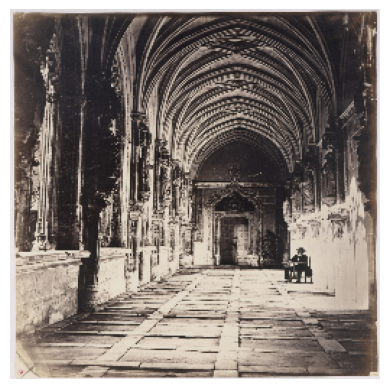

In [8]:
dataset.showImage(0)

#### Train \& Test Image Dataset

In [9]:
trainFolder = f"{image_dir}/TrainingImages/Goth"
imagePaths = glob.glob(f"{trainFolder}/*.jpg") + glob.glob(f"{trainFolder}/*.png")
trainDataset = ImageDataset(imagePaths=imagePaths)

testFolder = f"{image_dir}/TestImages/Goth"
imagePaths = glob.glob(f"{testFolder}/*.jpg") + glob.glob(f"{testFolder}/*.png")
testDataset = ImageDataset(imagePaths=imagePaths)

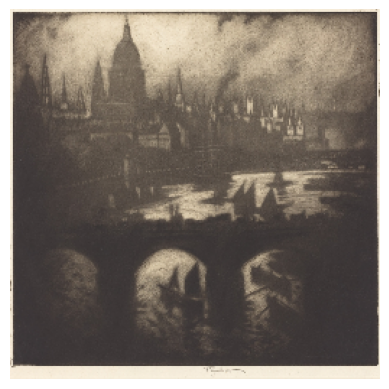

In [10]:
testDataset.showImage(0)

#### DataLoader

In [11]:
trainDataLoader = DataLoader(dataset=trainDataset, batch_size=1, shuffle=True)
testDataLoader = DataLoader(dataset=testDataset, batch_size=1, shuffle=True)

## <span style="color:#35BCE9">Phase II: Build GAN</span>

In [12]:
class Gan():
    def InitializeParameters(self, trainDataLoader, testDataLoader):
        self.INIT_LR = 2e-4
        self.BATCH_SIZE = 32
        self.EPOCHS = 1
        self.W_REG = 0.004
        
        self.lossD = None
        self.lossG = None
        self.randTorch = None
        
        self.trainDataLoader = trainDataLoader
        self.testDataLoader = testDataLoader
        
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
        
        self.GenCnn = GenCnn(100, 3).to(self.device)
        self.GraderCnn = GraderCnn(3).to(self.device)
        
        self.lossBce = nn.BCELoss()
        self.optG = Adam(self.GenCnn.parameters(), lr=self.INIT_LR, betas=(0.5, 0.999))
        self.optD = Adam(self.GraderCnn.parameters(), lr=self.INIT_LR, betas=(0.5, 0.999))
        
    
    def TrainNn(self):
        print("Using ", self.device, "for training")
        print("Start Training...")
        
        startTime = time.time()
        
        #training neural network
        for i in range(self.EPOCHS):
            for self.realImages in self.trainDataLoader:
                self.realImages = self.realImages.to(self.device)
                self.batchSize = self.realImages.size(0)
                
                self.realLabels = torch.ones(self.batchSize, 1, 1, 1, device=self.device)
                self.fakeLabels = torch.zeros(self.batchSize, 1, 1, 1, device=self.device)
                
                self.TrainGraderNn()
                self.TrainGeneratorNn()
            
            print(f"Epoch [{self.EPOCHS+1}/{self.EPOCHS}] | D Loss: {self.lossD.item():.4f} | G Loss: {self.lossG.item():.4f}")

            # Save a sample of generated images
            if (self.EPOCHS + 1) % 1 == 0:
                plt.figure(figsize=(5,5))
                with torch.no_grad():
                    sampleImages = self.GenCnn(torch.randn(16, 100, 1, 1, device=self.device)).cpu()
                sampleImages = (sampleImages + 1) / 2  # Rescale to [0,1]
                grid = torchvision.utils.make_grid(sampleImages, nrow=4)
                plt.imshow(grid.permute(1, 2, 0))
                plt.show()
        
        totalTime = time.time()-startTime
    
        print('Total Training Time: ', round(totalTime, 2), ' seconds\n')
                
            
    def TrainGraderNn(self):
        # Train Discriminator
        self.randTorch = torch.randn(self.batchSize, 100, 1, 1, device=self.device)
        self.fakeImages = self.GenCnn(self.randTorch)
        realLoss = self.lossBce(self.GraderCnn(self.realImages), self.realLabels)
        fakeLoss = self.lossBce(self.GraderCnn(self.fakeImages.detach()), self.fakeLabels)
        self.lossD = realLoss + fakeLoss
        
        self.optD.zero_grad()
        self.lossD.backward()
        self.optD.step()
                
    def TrainGeneratorNn(self):
        # Train Generator
        self.fakeImages = self.GenCnn(self.randTorch)
        self.lossG = self.lossBce(self.GraderCnn(self.fakeImages), self.realLabels)

        self.optG.zero_grad()
        self.lossG.backward()
        self.optG.step()

In [13]:
class GenCnn(Module):
    def __init__(self, zDim=100, imageChannels=3):
        super(GenCnn, self).__init__()
        
        self.model = nn.Sequential(
            nn.ConvTranspose2d(zDim, 1024, kernel_size=4, stride=1, padding=0),  # 1x1 → 4x4
            nn.BatchNorm2d(1024),
            nn.ReLU(),

            nn.ConvTranspose2d(1024, 512, kernel_size=4, stride=2, padding=1),  # 4x4 → 8x8
            nn.BatchNorm2d(512),
            nn.ReLU(),

            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),  # 8x8 → 16x16
            nn.BatchNorm2d(256),
            nn.ReLU(),

            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),  # 16x16 → 32x32
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),  # 32x32 → 64x64
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),  # 64x64 → 128x128
            nn.BatchNorm2d(32),
            nn.ReLU(),

            nn.ConvTranspose2d(32, imageChannels, kernel_size=4, stride=2, padding=1),  # 128x128 → 256x256
            nn.Tanh()  # Output is scaled between [-1,1]
        )

    def forward(self, x):
        return self.model(x)

In [14]:
class GraderCnn(Module):
    def __init__(self, imageChannels):
        super(GraderCnn, self).__init__()
        
        self.model = nn.Sequential(
            nn.Conv2d(imageChannels, 32, kernel_size=4, stride=2, padding=1),  # 256x256 → 128x128
            nn.LeakyReLU(0.2),

            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),  # 128x128 → 64x64
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),

            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),  # 64x64 → 32x32
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),

            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),  # 32x32 → 16x16
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),

            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),  # 16x16 → 8x8
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),

            nn.Conv2d(512, 1024, kernel_size=4, stride=2, padding=1),  # 8x8 → 4x4
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(0.2),

            nn.Conv2d(1024, 1, kernel_size=4, stride=1, padding=0),  # 4x4 → 1x1
            nn.Sigmoid()  # Output probability (real vs. fake)
        )


    def forward(self, x):
        return self.model(x)
    

In [15]:
gan = Gan()
gan.InitializeParameters(trainDataLoader=trainDataLoader, testDataLoader=testDataLoader)

## <span style="color:#35BCE9">Phase III: Train GAN</span>

Using  cpu for training
Start Training...
Epoch [2/1] | D Loss: 0.8675 | G Loss: 22.6138


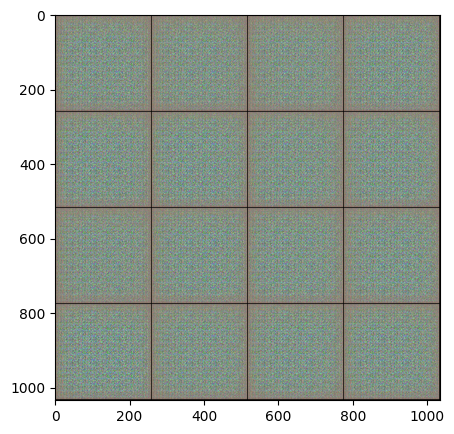

Total Training Time:  2.05  seconds



In [16]:
gan.TrainNn()

## <span style="color:#35BCE9">Phase IV: Generate Images</span>